In [181]:
import numpy as np
from sklearn.datasets import make_moons
from sklearn.neighbors import kneighbors_graph
from scipy import sparse
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import homogeneity_score, completeness_score,v_measure_score

random_state = 213
np.random.seed(random_state)

### 1. Construction of k-nearest graph from dataset

In [127]:
data_size = 150
features,y = make_moons(n_samples=data_size, noise=0.07, random_state=213)
print(x.shape, y.shape)

data_size = features.shape[0]

(150, 1) (150,)


In [128]:
features.shape, y.shape

((150, 2), (150,))

We can set mode of connectivity as 'distance' for the edges to represent the distance between 2 nodes or specify 'connectivity' to denote presence or absence of an edge between them with edge weight 1 or 0.

In case of extreme data points/outliers in the dataset, the outliers in the resulting may even have no connectivity with even a single nearest neighbors. Many real datasets have extreme data points. These data points  can be excluded in the beginning.

In [144]:
n_neighbors = 10
knn_dist_graph = kneighbors_graph(X=features, 
                             n_neighbors=n_neighbors,
                             mode='distance',
                             metric='euclidean',
                             n_jobs=6)
n_neighbors

10

In [136]:
knn_dist_graph.shape

(150, 150)

It returns a sparse graph with edges representing the distance between our data points. The distance of the first data points with its 50 neighbors is shown below. Note the sparsity of the graph and it will have continuous value representing distance at only those places/indices in the matrix which corresponds to its k nearest neighbours, the rest will be zero.



In [137]:
knn_dist_graph.todense()[0][:,:50]

matrix([[0.        , 0.        , 0.07266041, 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.06969749, 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ]])

This dataset is commonly used to find groups within the data points where similar data points lie in the same class or cluster.

Similarly in other such cases when you want to capture similarity within the data points rather than the distance, we can convert this graph to a similarity based graph using a Gaussian kernel with its width (sigma = 1 ) and distance is euclidean distance in the non zero place in the sparse graph above.

$W_{ij} = \exp{\frac{-d(x1,x2)^2}{2\sigma ^2}}$



In [138]:
sigma = 1

Note that the locations with distance 0 here means the distance is beyond the largest distance of k nearest neighbors. This value can be interpreted as highest similarity when fed to the Gaussian kernel. So we will only apply this kernel to indices containing distances.

In [145]:
  similarity_graph = sparse.csr_matrix(knn_dist_graph.shape)
  nzeroindices = knn_dist_graph.nonzero()
  similarity_graph[nzeroindices] = np.exp(-np.asarray(knn_dist_graph[nzeroindices])**2 / 2.0 * sigma**2)


/usr/local/lib/python3.6/dist-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


This graph may be assymmetric since it is based on k-nearest neighbors. We need to make this graph symmetric for reasons we will know next in properties of Laplacian. We add the transpose of its graph to itself and divide all the values by 2. 



In [146]:
similarity_graph = 0.5 * (similarity_graph + similarity_graph.T) 

In [147]:
similarity_graph.todense()[0][:,:50]

matrix([[0.        , 0.        , 0.99736371, 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.98128411, 0.        ,
         0.        , 0.        , 0.98821653, 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.99757408, 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ]])

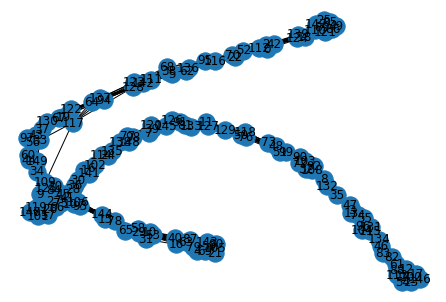

In [148]:
# Let's see how the graph looks like
nx_graph = nx.from_scipy_sparse_matrix(similarity_graph)

nx.draw(nx_graph, with_labels=True)
plt.show()

### 2. Deriving degree matrix from graph

$D = Diag(d_1, d_2, ...,d_n)$

$d_i = \sum_{k=1}^N W_{ik}$

Where W is our similarity matrix with N data points

In [149]:
degree_matrix = similarity_graph.sum(axis=1)
degree_matrix.shape

(150, 1)

In [150]:
degree_matrix[:5]

matrix([[ 9.88985997],
        [ 9.84957185],
        [ 9.40776641],
        [10.39306058],
        [10.36893174]])

In [151]:
# Checking for outlier data point having no neighbor i.e degree = 0
degree_matrix[degree_matrix == 0]

matrix([], shape=(1, 0), dtype=float64)

At this point you can see any points which have degree equal to zero as outliers. 

### 3. Constructing Normal Laplacian

L = D - W

In [152]:
np.asarray(degree_matrix).shape

(150, 1)

In [153]:
np.diag(np.asarray(degree_matrix).reshape(data_size,))

array([[ 9.88985997,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  9.84957185,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  9.40776641, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  9.88244354,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         9.87138597,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        , 10.81779121]])

In [154]:
diagonal_matrix = np.diag(np.asarray(degree_matrix).reshape(data_size,))
L =  diagonal_matrix - similarity_graph

In [155]:
L

matrix([[ 9.88985997,  0.        , -0.99736371, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  9.84957185,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [-0.99736371,  0.        ,  9.40776641, ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  9.88244354,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          9.87138597,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        , 10.81779121]])

Note:- By subtracting the similarity matrix from the degree matrix, the effect of cycles in a graph gets nullified. Finally, the Laplacian conatains the degree on diagonals and negative of edge weights in the rest of the matrix.


In [156]:
# We can also obtain the Laplacian using scipy 

L = sparse.csgraph.laplacian(csgraph=similarity_graph)

### Properties of Laplacian

1. Real symmetric

Because its real and symmetric its eigen values are real and its eigen vectors orthogonal.

2. Positive semi-definite

The Laplacian has atleast one eigen value equal to 0. We can check this by its quadratic form. If $x$ is a n x 1 column vector , then $q = x'Lx$ is its quadratic form. 

A quadratic form is positive semi-definite if -

$ Q ≥ 0 $ for all x and Q = 0 for some $ x \ne 0 $

We will set x to be a column vector of 1's.

In [157]:
x = np.ones(shape=(data_size,1), dtype=int)

Q = np.dot(np.dot(x.T, L.todense()), x)

Q.round(10)

array([[-0.]])

Any column vector x containing same values throughout, will result in quadratic form equal to 0.
3. The number of zero eigen values of Laplacian is equal to the number of connected components of the graph



In [158]:
# Finding eigen values and eigen vectors
e, evecs = np.linalg.eig(L.todense())
e.shape, evecs.shape

((150,), (150, 150))

In [159]:
# No. of eigen values equal to 0
e_rounded_off = e.round(5)
e_rounded_off[e_rounded_off == 0].shape

(1,)

In [160]:
# No. of connected components
nx.number_connected_components(nx_graph)

1

4. Two data points similar to each other having high edge weight will have similar values at their corresponding indices in the resulting eigen vectors.
One of these eigen vectors in Fiedler vector - Eigen vector correponding to the smallest non-zero eigen value.

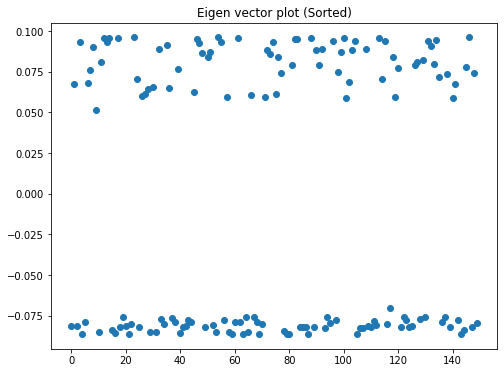

In [168]:
plt.figure(figsize=(8,6))
plt.scatter(np.arange(data_size), evecs[:,1].tolist())
plt.title("Eigen vector plot (Sorted)")
plt.show()

The data points are quite well separated by sign. 



### Application of Graph Laplacian 

By extension of all the above properties, and the fact that the eigen vector separates data points in groups, it is used for clustering. This method is called **Spectral clustering**.

This is performed by choosing a threshold to separate data points into 2 clusters from the 1st smallest eigen vector. For more than 2 clusters, we can use Kmeans algorithm to obtain k clusters directly from the first smallest K eigen vectors.


In [162]:
# Sort the eigen value 
sorted_indices = np.argsort(e)

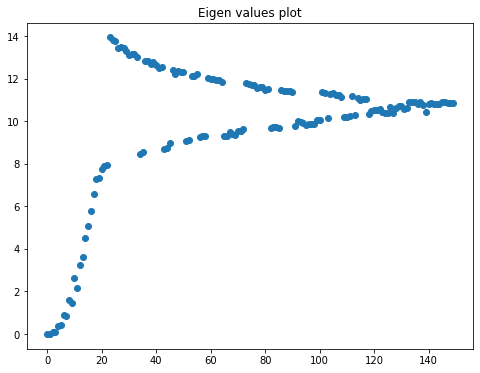

In [169]:
plt.figure(figsize=(8,6))
plt.scatter(np.arange(data_size), e)
plt.title("Eigen values plot")
plt.show()

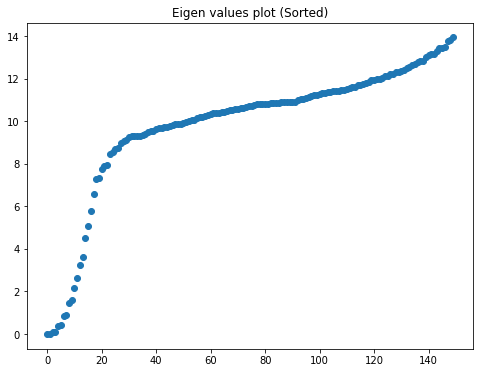

In [165]:
plt.figure(figsize=(8,6))
plt.scatter(np.arange(data_size), np.sort(e))
plt.title("Eigen values plot (Sorted)")
plt.show()

 Use Fiedler vector to partition data points

The Fiedler vector is the eigen vector corresponding to smallest non-zero eigen value. Indices of values below 0 are assigned to cluster 1 and the indices of rest of them are assigned to cluster 2. 

We are able to use this vector this way because this normalized eigen vector is a scaled version of the indicator vector. An indicator vector is associated with every non-zero eigen value of a matrix. Each indicator vector is also orthogonal to each other and ideally conatains binary values 0 or 1 to indicate cluster membership.

In this case, instead of indicator vector containing 0's and 1's, we have signed continuous values.

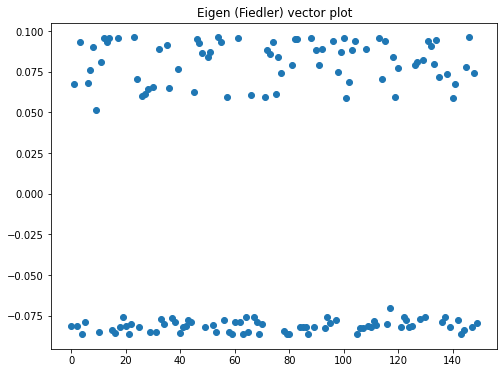

In [171]:
# Get smallest non-zero eigen value's index for obtaining partition to cluster
fiedler_index = sorted_indices[1]
fiedler_index

# The eigen vector for smallest non-zero eigen value i.e plotting the Fiedler vector
# Plotting eigen values
plt.figure(figsize=(8,6))
plt.scatter(np.arange(data_size), evecs[:,fiedler_index].tolist())
plt.title("Eigen (Fiedler) vector plot")
plt.show()

fiedler_vector = evecs[:,fiedler_index].copy()

# Thresholding the values in this eigen vector at 0
fiedler_vector[fiedler_vector < 0.0] = 0
fiedler_vector[fiedler_vector > 0.0] = 1

new_labels = np.asarray(fiedler_vector)[:,0]

#### Results


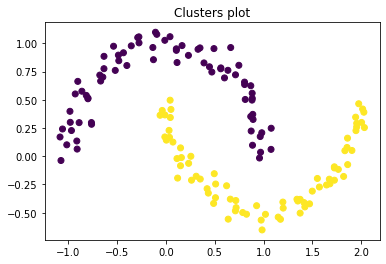

In [175]:
plt.scatter(features[:,0], features[:,1], c=new_labels.astype(float))
plt.title("Clusters plot")
plt.show()

Evaluation with entropy based external clustering evaluation measures

In [182]:
homogeneity_score(y, new_labels), completeness_score(y, new_labels), v_measure_score(y, new_labels)

(1.0, 1.0, 1.0)

### Comparison with Kmeans 

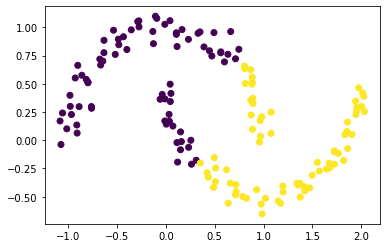

In [183]:
num_clusters = 2
kmean_labels = KMeans(n_clusters=num_clusters, random_state=random_state, n_jobs=6).fit_predict(features)
plt.scatter(features[:,0], features[:,1], c=kmean_labels.astype(float))
plt.show()

In [184]:
homogeneity_score(y, kmean_labels), completeness_score(y, kmean_labels), v_measure_score(y, kmean_labels)

(0.1836464702880451, 0.1837407327840609, 0.18369358944333708)

### Why Eigen value system, though?
Because the eigen value system approximates a graph cut.

$Cut(V1,V2) = \sum_{i \in V_1, j \in V_2} W_{ij} $

Where the graph is bipartitioned into V1 & V2.

In the above approach, the eigen values are approximating Normalized graph cut.

$ NCut(V1,V2) = \frac{Cut(V_1, V_2)}{Vol(V_1)} + \frac{Cut(V_1, V_2)}{Vol(V_2)}$

### So how is it so?
The above equation of NCut can be re-expressed as Rayleigh's quotient, whose minimum is obtained by the smallest eigen value from a generalized eigen value problem.
Let x be an N dimensional indicator vector where $x_i = 1$ if the graph node i is in $V_1$ and 0 otherwise.


$min_x Ncut(x) = min_y \frac{y^T(D-W)y}{y^Ty}$

subject to one of the conditions $y^TD1=0$ 

where $y$ is also subject to constraints as that of our indicator vector $x$.


This way the graph partitioning problem gets converted to clustering problem.

